In [2]:
from utils import auto_wonder_pipeline, process_data_rd, filter

In [ ]:
suicide study: Residence HHS Regions, Gender, Year, Single Race 6, Hispanic Origin
natural disaster study: State, month(year), age group, cause of death, 

In [3]:
observed_outcome = [
    "Diseases of the circulatory system",
    "Diseases of the respiratory system",
]
short_outcome = ["circulatory system", "respiratory system"]

df_observed = auto_wonder_pipeline(
    observed_outcome=observed_outcome,
    short_outcome=short_outcome,
)


df_1 = process_data_rd(df_observed, state="CA", disaster_date="2015-9-22")

In [5]:
df_observed

cirdeaths       date  resdeaths
state time                                       
AK    2010-01-01       78.0 2010-01-01       25.0
      2010-02-01       74.0 2010-02-01       23.0
      2010-03-01       64.0 2010-03-01       23.0
      2010-04-01       75.0 2010-04-01       41.0
      2010-05-01       62.0 2010-05-01       29.0
...                     ...        ...        ...
WY    2020-08-01      118.0 2020-08-01       47.0
      2020-09-01      145.0 2020-09-01       43.0
      2020-10-01      144.0 2020-10-01       56.0
      2020-11-01      122.0 2020-11-01       41.0
      2020-12-01      143.0 2020-12-01       61.0

[6732 rows x 3 columns]

<AxesSubplot:xlabel='date'>

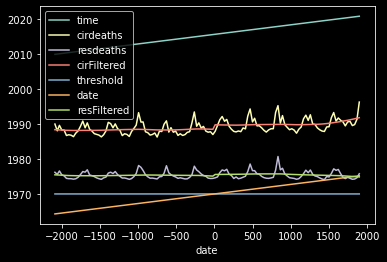

In [3]:
filter(df_1)
df_1.plot()

In [4]:
df_1

,time,cirdeaths,resdeaths,cirFiltered,threshold,date,resFiltered
date,,,,,,,
-2090,2010-01-01,7313.0,2268.0,6724.466389,0,-2090,2000.792920
-2059,2010-02-01,6610.0,2045.0,6709.697900,0,-2059,1986.490761
-2031,2010-03-01,7177.0,2407.0,6695.297244,0,-2031,1972.355607
-2000,2010-04-01,6692.0,2000.0,6681.569945,0,-2000,1958.591031
-1970,2010-05-01,6683.0,1896.0,6669.122588,0,-1970,1945.672257
...,...,...,...,...,...,...,...
1775,2020-08-01,7606.0,1643.0,7758.604826,1,1775,1846.677458
1806,2020-09-01,7156.0,1537.0,7810.925183,1,1806,1830.215733
1836,2020-10-01,7259.0,1563.0,7865.799495,1,1836,1814.097083


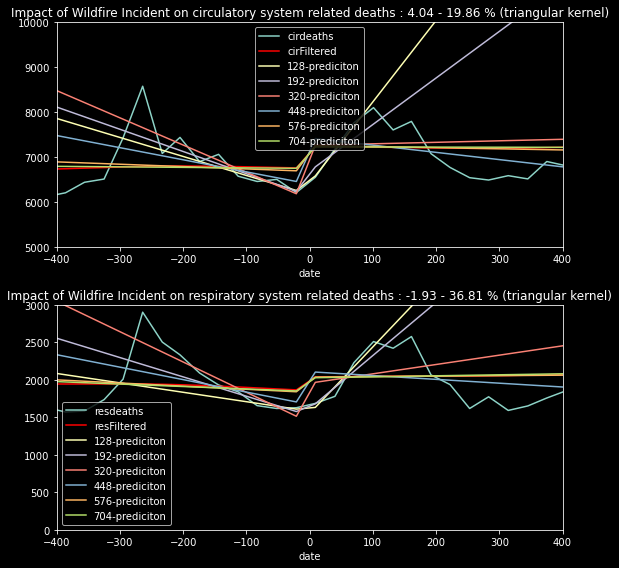

In [22]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from utils import kernel
import numpy as np
plt.figure(figsize=(8, 8))

for p, short_o in enumerate(short_outcome, 1):
    ax = plt.subplot(2, 1, p)
    ax.set_xlim([-400,400])
    ax.set_ylim([5000,10000] if short_o == "circulatory system" else [0,3000])
    df_1.plot(x="date", y="{}deaths".format(short_o[:3]), ax=ax)
    m = {
        (k + 1) * 64: smf.wls(
            f"{short_o[:3]}deaths~date*threshold",
            df_1,
            weights=kernel(df_1["date"], c=0, h=(k + 1) * 64),
        ).fit()
        for k in [1,2,4,6,8,10]
    }
    ate_pct = {
        window: 100
        * (
            (m_k.params["threshold"] + m_k.params["Intercept"])
            / m_k.params["Intercept"]
            - 1
        )
        for window, m_k in m.items()
    }

    df_1[["{}{}".format(short_o[:3], "Filtered")]].plot(ax=ax, color="red", label="filtered")

    df_1.assign(
        **{
            "{}-prediciton".format(window): m_k.fittedvalues
            for window, m_k in m.items()
        }
    ).plot(
        x="date", y=["{}-prediciton".format(window) for window in m.keys()], ax=ax
    )


    np.round(min(ate_pct.values()), 2), np.round(max(ate_pct.values()), 2)
    plt.title(
        f"Impact of Wildfire Incident on {short_o} related deaths : {np.round(min(ate_pct.values()), 2)} - {np.round(max(ate_pct.values()), 2)} % (triangular kernel)"
    )

plt.tight_layout()